## Analyzing ACN Data to Understand the Charging Behavior Of EV Owners

Electric vehicles (EVs) are growing in popularity globally due to their potential contribution in reducing the dependency on fossil fuels and greenhouse gas emissions. However, the growth of EVs in recent years has raised the question of how to charge EVs at scale while avoiding adverse effects on the power grid and public infrastructure. An important part of addressing this question is understanding consumer charging behavior. 

In this project, I analyze a dataset of workplace EV charging obtained from two Adaptive Charging Networks (ACN) located in California. The dataset includes 30,814 charging sessions from ACN located on JPL's campus and 18,021 charging sessions from ACN located on Caltech's campus different locations during the period 11/01/2018-9/01/2021. The end goal of this project is to build a model using Gaussian mixture models (GMMs) that can learn the underlying joint distribution of arrival time, charging session duration, and energy delivered. To evaluate how well our GMM fits the underlying distribution, we will generate samples using our trained model and compare their distribution with the empirical distribution from our test set.

Beside using the model to gain insight about user charging behavior, the the trained model can also be utilized to generate samples consisting of arrival time, charging session duration and energy delivered to simulate a real world charging enviroment, and this simulated enviroment can then be used when developing and testing smart EV charging systems.



#### Basic Libraries

In [126]:
import requests
import pandas as pd
import numpy as np
import json
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.style.use('seaborn')

#### Loading Datasets
I tried to use the API to download the data, but getting the api to work with the pagination process proved to difficult. Instead I used the Web interface to download the relavant datasets in JSON format from Caltech and JPL ASN to my local computer, and converted them to Pandas dataframes as follows.

In [127]:
with open(r'C:\Users\karabulutc\Jupyter Notebooks\TDI - Capstone\acndata_sessions_11_01_2018-9_01_2021_JPL.json') as JPL:
  dataJPL = json.load(JPL)


In [128]:
with open(r'C:\Users\karabulutc\Jupyter Notebooks\TDI - Capstone\acndata_sessions_11_01_2018-9_01_2021_Caltech.json') as Caltech:
  dataCaltech = json.load(Caltech)

In [129]:
dfJPL = pd.json_normalize(dataJPL['_items'])

In [130]:
dfCal = pd.json_normalize(dataCaltech['_items'])

#### A first look and missing values

The data fields in the dataframe below are self explanatory, but the precise description of each field can be found [here.](https://ev.caltech.edu/dataset)

In [131]:
dfJPL.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5c36680ef9af8b4639a8ea37,0001,"Thu, 01 Nov 2018 12:24:45 GMT","Thu, 01 Nov 2018 22:47:54 GMT","Thu, 01 Nov 2018 16:29:39 GMT",12.037,1_1_193_827_2018-11-01 12:24:44.795402,0001,AG-1F02,1-1-193-827,America/Los_Angeles,000000404,"[{'WhPerMile': 600, 'kWhRequested': 24.0, 'mil..."
1,5c36680ef9af8b4639a8ea38,0001,"Thu, 01 Nov 2018 12:36:35 GMT","Fri, 02 Nov 2018 01:06:29 GMT","Thu, 01 Nov 2018 18:32:17 GMT",36.737,1_1_178_824_2018-11-01 12:36:34.589955,0001,AG-1F07,1-1-178-824,America/Los_Angeles,000000933,"[{'WhPerMile': 325, 'kWhRequested': 39.0, 'mil..."
2,5c36680ef9af8b4639a8ea39,0001,"Thu, 01 Nov 2018 12:40:38 GMT","Thu, 01 Nov 2018 21:05:55 GMT","Thu, 01 Nov 2018 16:40:17 GMT",11.944,1_1_194_821_2018-11-01 12:40:38.037593,0001,AG-1F13,1-1-194-821,America/Los_Angeles,000000651,"[{'WhPerMile': 500, 'kWhRequested': 20.0, 'mil..."
3,5c36680ef9af8b4639a8ea3a,0001,"Thu, 01 Nov 2018 12:48:14 GMT","Thu, 01 Nov 2018 22:36:11 GMT","Thu, 01 Nov 2018 17:20:16 GMT",10.588,1_1_178_823_2018-11-01 12:48:14.268383,0001,AG-1F08,1-1-178-823,America/Los_Angeles,000000406,"[{'WhPerMile': 500, 'kWhRequested': 20.0, 'mil..."
4,5c36680ef9af8b4639a8ea3b,0001,"Thu, 01 Nov 2018 12:50:57 GMT","Fri, 02 Nov 2018 00:03:22 GMT","Thu, 01 Nov 2018 14:51:47 GMT",5.961,1_1_191_789_2018-11-01 12:50:56.998469,0001,AG-4F52,1-1-191-789,America/Los_Angeles,000000483,"[{'WhPerMile': 350, 'kWhRequested': 7.0, 'mile..."


In [132]:
dfJPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30814 entries, 0 to 30813
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               30814 non-null  object 
 1   clusterID         30814 non-null  object 
 2   connectionTime    30814 non-null  object 
 3   disconnectTime    30814 non-null  object 
 4   doneChargingTime  30049 non-null  object 
 5   kWhDelivered      30814 non-null  float64
 6   sessionID         30814 non-null  object 
 7   siteID            30814 non-null  object 
 8   spaceID           30814 non-null  object 
 9   stationID         30814 non-null  object 
 10  timezone          30814 non-null  object 
 11  userID            29765 non-null  object 
 12  userInputs        29765 non-null  object 
dtypes: float64(1), object(12)
memory usage: 3.1+ MB


In [133]:
dfCal.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5c2e858ef9af8b13dab074de,0039,"Thu, 01 Nov 2018 13:55:03 GMT","Thu, 01 Nov 2018 15:10:42 GMT","Thu, 01 Nov 2018 15:10:38 GMT",4.327000,2_39_89_25_2018-11-01 13:55:02.815279,0002,CA-315,2-39-89-25,America/Los_Angeles,000000743,"[{'WhPerMile': 500, 'kWhRequested': 5.0, 'mile..."
1,5c2e858ef9af8b13dab074df,0039,"Thu, 01 Nov 2018 13:57:00 GMT","Thu, 01 Nov 2018 18:45:20 GMT","Thu, 01 Nov 2018 15:17:51 GMT",6.427000,2_39_79_380_2018-11-01 13:57:00.128478,0002,CA-489,2-39-79-380,America/Los_Angeles,000000066,"[{'WhPerMile': 357, 'kWhRequested': 14.28, 'mi..."
2,5c2e858ef9af8b13dab074e0,0039,"Thu, 01 Nov 2018 14:05:58 GMT","Thu, 01 Nov 2018 15:14:00 GMT","Thu, 01 Nov 2018 15:13:52 GMT",6.930000,2_39_95_27_2018-11-01 14:05:57.543149,0002,CA-319,2-39-95-27,America/Los_Angeles,000000566,"[{'WhPerMile': 278, 'kWhRequested': 11.12, 'mi..."
3,5c2e858ef9af8b13dab074e1,0039,"Thu, 01 Nov 2018 14:06:08 GMT","Thu, 01 Nov 2018 22:20:43 GMT","Thu, 01 Nov 2018 22:18:58 GMT",0.917000,2_39_79_376_2018-11-01 14:06:07.581931,0002,CA-324,2-39-79-376,America/Los_Angeles,None,None
4,5c2e858ef9af8b13dab074e2,0039,"Thu, 01 Nov 2018 14:07:28 GMT","Thu, 01 Nov 2018 18:35:02 GMT","Thu, 01 Nov 2018 17:40:55 GMT",19.476567,2_39_78_360_2018-11-01 14:07:28.105688,0002,CA-322,2-39-78-360,America/Los_Angeles,000000560,"[{'WhPerMile': 273, 'kWhRequested': 21.84, 'mi..."


In [134]:
dfCal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18021 entries, 0 to 18020
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               18021 non-null  object 
 1   clusterID         18021 non-null  object 
 2   connectionTime    18021 non-null  object 
 3   disconnectTime    18021 non-null  object 
 4   doneChargingTime  16038 non-null  object 
 5   kWhDelivered      18021 non-null  float64
 6   sessionID         18021 non-null  object 
 7   siteID            18021 non-null  object 
 8   spaceID           18021 non-null  object 
 9   stationID         18021 non-null  object 
 10  timezone          18021 non-null  object 
 11  userID            15390 non-null  object 
 12  userInputs        15390 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.8+ MB


In [135]:
dfJPL.isna().sum()

_id                    0
clusterID              0
connectionTime         0
disconnectTime         0
doneChargingTime     765
kWhDelivered           0
sessionID              0
siteID                 0
spaceID                0
stationID              0
timezone               0
userID              1049
userInputs          1049
dtype: int64

In [136]:
dfCal.isna().sum()

_id                    0
clusterID              0
connectionTime         0
disconnectTime         0
doneChargingTime    1983
kWhDelivered           0
sessionID              0
siteID                 0
spaceID                0
stationID              0
timezone               0
userID              2631
userInputs          2631
dtype: int64

 In both datasets we see that there are missing values in categories `doneChargingTime`, `userID`, and `userInputs`. We will ignore these categories for now as they are not relevant to the model currently being considered. 

In [137]:
dfJPL.drop(['doneChargingTime','userID','userInputs'], axis=1, inplace=True)

In [138]:
dfCal.drop(['doneChargingTime','userID','userInputs'], axis=1, inplace=True)

#### Some data wrangling, feature engineering, and data visualization
We are interested in the distribution of arrival time, duration and the total energy (in kWh) delivered. Our data frame already contains the info about the total energy in the column `kWhDelivered`, and the values are already in the desirable form.
The info about arrivals is contained in the column `connectionTime`, and the values for the duration can be obtained by simply calculating `disconnectTime` - `connectionTime`. This, unfortunately, will not work since we need to first convert these columns to datetime like values. We also need to convert the timezone from GMT to PST.

#### JPL Dataset

In [140]:
#Convert the values in the columns connectionTime and disconnectTime to datetime like values, and timezone for each value from GMT to PST.
dfJPL['connectionTimeDate'] =pd.to_datetime(dfJPL['connectionTime']).dt.tz_convert('America/Los_Angeles')
dfJPL['disconnectTimeDate'] =pd.to_datetime(dfJPL['disconnectTime']).dt.tz_convert('America/Los_Angeles')

#Extract the hour of the arrivals and departures. 
dfJPL['arrivals'] =dfJPL['connectionTimeDate'].dt.hour
dfJPL['departures'] =dfJPL['disconnectTimeDate'].dt.hour

#Extract the day and the month for each charging session.  
dfJPL['dayOfTheWeek'] = dfJPL['connectionTimeDate'].dt.day_name()
dfJPL['monthOfTheYear'] = dfJPL['connectionTimeDate'].dt.month_name()

#Calculate the duration for each charging session and convert the values to hours.
dfJPL['duration'] = ((pd.to_datetime(dfJPL['disconnectTimeDate']) - 
                            pd.to_datetime(dfJPL['connectionTimeDate']))
                                .dt.total_seconds() / 3600)


In [141]:
dfJPL.drop(['connectionTime','disconnectTime','timezone'], axis=1)

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,connectionTimeDate,disconnectTimeDate,arrivals,departures,dayOfTheWeek,monthOfTheYear,duration
0,5c36680ef9af8b4639a8ea37,0001,12.037,1_1_193_827_2018-11-01 12:24:44.795402,0001,AG-1F02,1-1-193-827,2018-11-01 05:24:45-07:00,2018-11-01 15:47:54-07:00,5,15,Thursday,November,10.385833
1,5c36680ef9af8b4639a8ea38,0001,36.737,1_1_178_824_2018-11-01 12:36:34.589955,0001,AG-1F07,1-1-178-824,2018-11-01 05:36:35-07:00,2018-11-01 18:06:29-07:00,5,18,Thursday,November,12.498333
2,5c36680ef9af8b4639a8ea39,0001,11.944,1_1_194_821_2018-11-01 12:40:38.037593,0001,AG-1F13,1-1-194-821,2018-11-01 05:40:38-07:00,2018-11-01 14:05:55-07:00,5,14,Thursday,November,8.421389
3,5c36680ef9af8b4639a8ea3a,0001,10.588,1_1_178_823_2018-11-01 12:48:14.268383,0001,AG-1F08,1-1-178-823,2018-11-01 05:48:14-07:00,2018-11-01 15:36:11-07:00,5,15,Thursday,November,9.799167
4,5c36680ef9af8b4639a8ea3b,0001,5.961,1_1_191_789_2018-11-01 12:50:56.998469,0001,AG-4F52,1-1-191-789,2018-11-01 05:50:57-07:00,2018-11-01 17:03:22-07:00,5,17,Thursday,November,11.206944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30809,6146870bf9af8b603e05e923,0001,5.857,1_1_179_800_2021-08-31 21:20:07.773170,0001,AG-3F32,1-1-179-800,2021-08-31 14:20:19-07:00,2021-08-31 16:34:33-07:00,14,16,Tuesday,August,2.237222
30810,6146870bf9af8b603e05e924,0001,6.726,1_1_191_778_2021-08-31 21:32:25.000834,0001,AG-4F43,1-1-191-778,2021-08-31 14:32:32-07:00,2021-08-31 17:41:37-07:00,14,17,Tuesday,August,3.151389
30811,6146870bf9af8b603e05e925,0001,10.508,1_1_193_816_2021-08-31 22:15:42.043363,0001,AG-1F05,1-1-193-816,2021-08-31 15:16:00-07:00,2021-08-31 17:24:11-07:00,15,17,Tuesday,August,2.136389
30812,6146870bf9af8b603e05e926,0001,1.868,1_1_191_808_2021-08-31 22:28:26.847558,0001,AG-4F35,1-1-191-808,2021-08-31 15:28:36-07:00,2021-08-31 16:28:45-07:00,15,16,Tuesday,August,1.002500


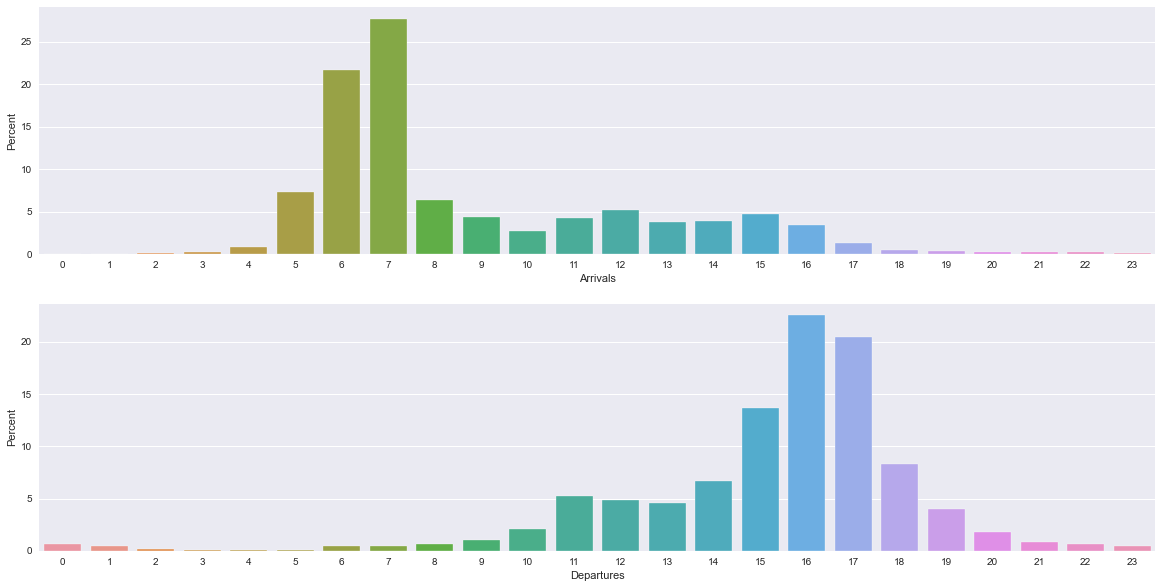

In [159]:
#Distribution of the arrivals and departures by hours.

fig, ax = plt.subplots(2, figsize = (20,10))
sns.barplot(x="arrivals",
                 y="arrivals",
                 data=dfJPL,
                
                 estimator=lambda x: len(x) / len(dfJPL) * 100, ax=ax[0]
                 )

sns.barplot(x="departures",
                 y="departures",
                 data=dfJPL,
                 
                 estimator=lambda x: len(x) / len(dfJPL) * 100, ax=ax[1]
                 )

ax[0].set(xlabel="Arrivals")
ax[0].set(ylabel="Percent")
ax[1].set(xlabel="Departures")
ax[1].set(ylabel="Percent")



plt.show()

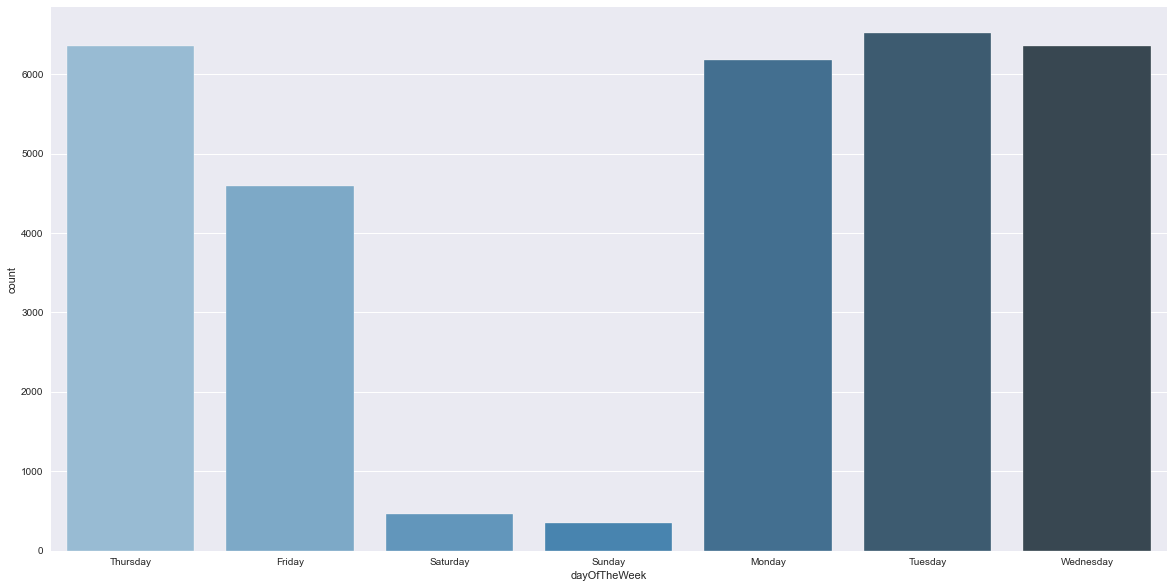

In [160]:
#Distribution of charging sessions by days of the week.
fig, ax = plt.subplots( figsize = (20,10))
ax = sns.countplot(data = dfJPL, x = 'dayOfTheWeek', ax=ax, palette = ("Blues_d"))

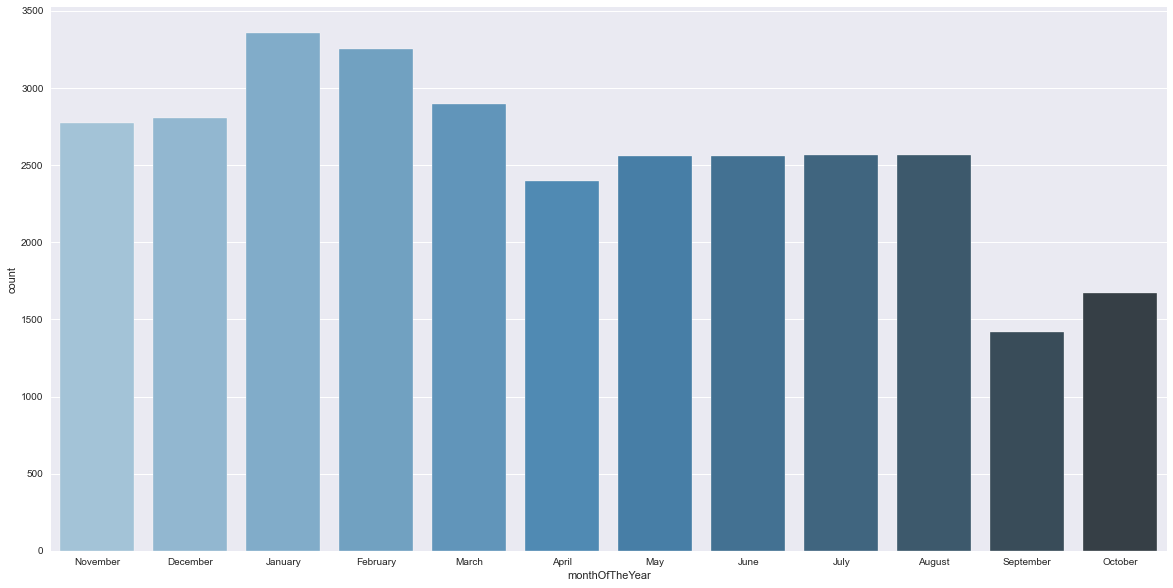

In [161]:
#Distribution of charging sessions by months of the year.
fig, ax = plt.subplots( figsize = (20,10))
ax = sns.countplot(data = dfJPL, x = 'monthOfTheYear', ax=ax, palette = ("Blues_d"))

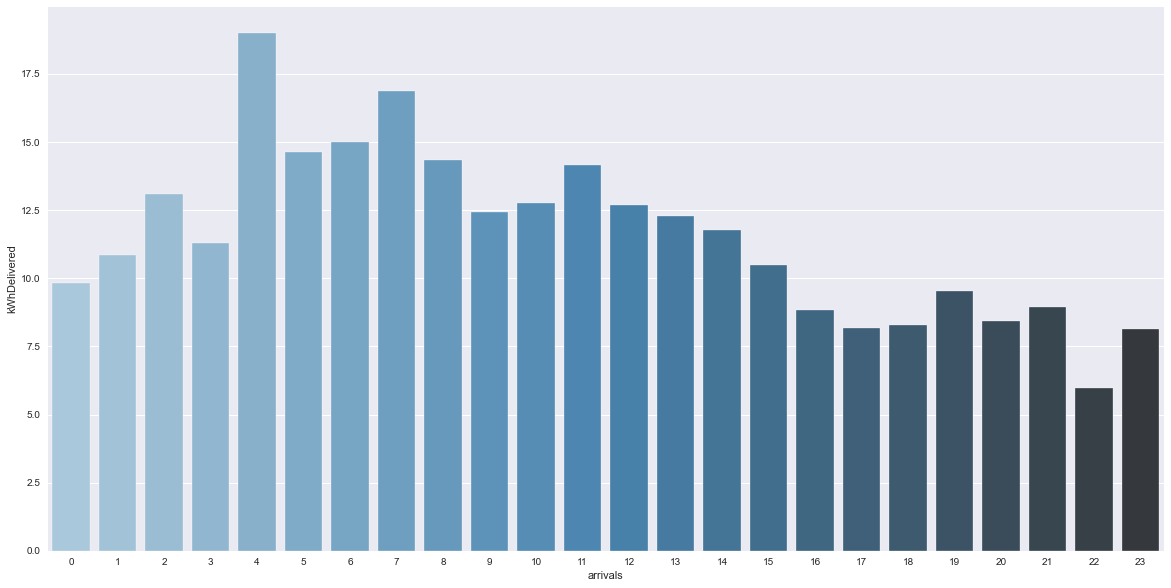

In [143]:
#Mean energy delivered by hour.
fig, ax = plt.subplots( figsize = (20,10))
ax = sns.barplot(data = dfJPL, x = 'arrivals', y='kWhDelivered', ax=ax, palette = ("Blues_d"),ci=None)

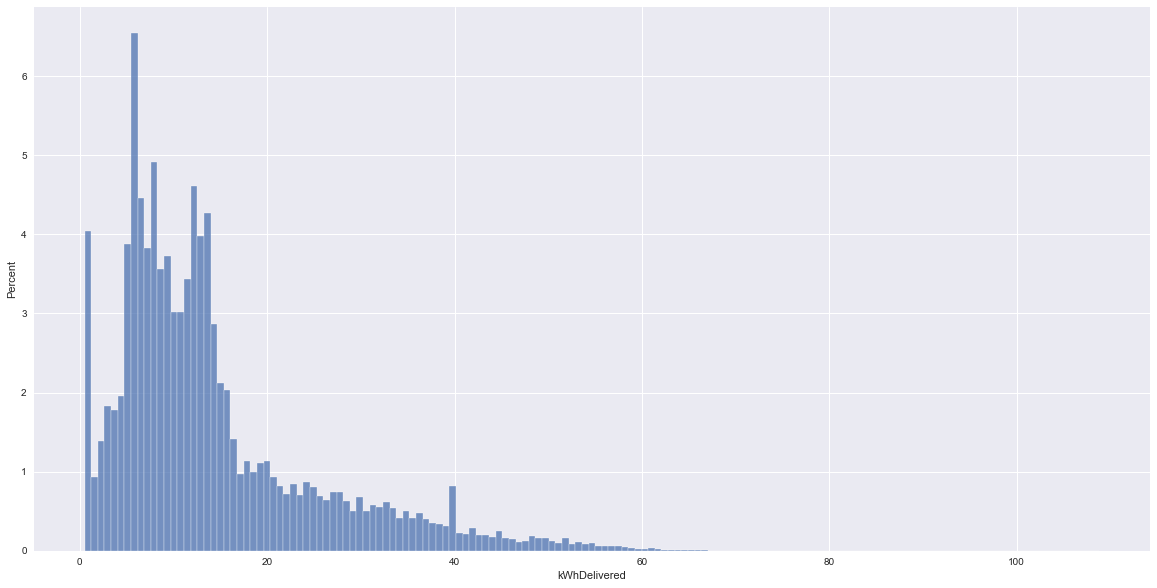

In [162]:
#Distribution of enery delivered.
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(data=dfJPL, x='kWhDelivered', stat='percent')
plt.show()


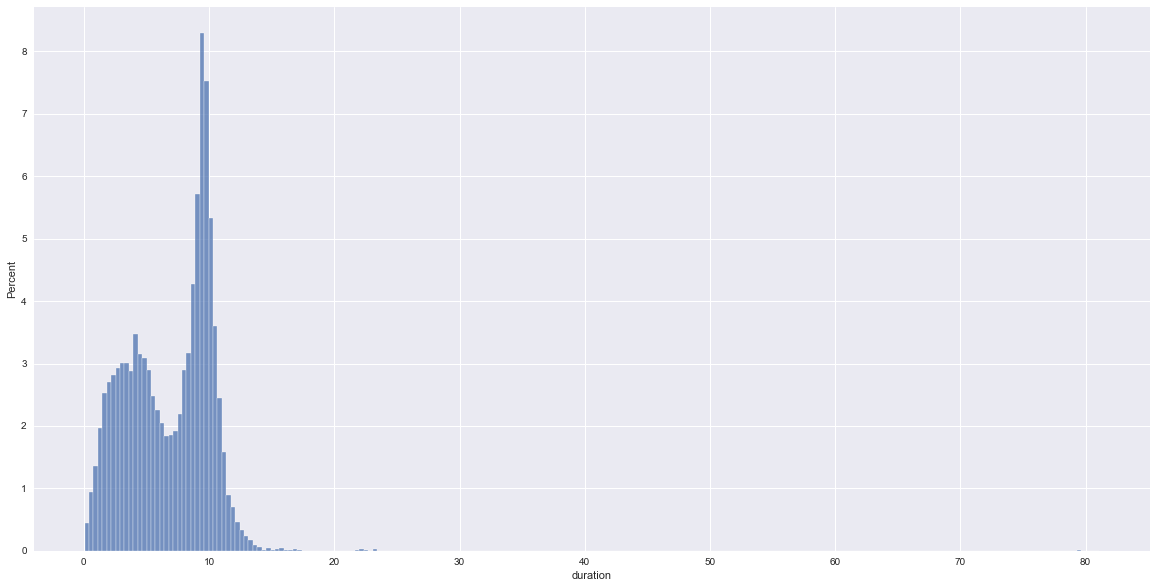

In [163]:
#Distribution of duration.
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(data=dfJPL, x='duration', stat='percent')
plt.show()

#### Caltech Dataset

In [146]:
#Convert the values in the columns connectionTime and disconnectTime to datetime like values, and timezone for each value from GMT to PST.
dfCal['connectionTimeDate'] =pd.to_datetime(dfCal['connectionTime']).dt.tz_convert('America/Los_Angeles')
dfCal['disconnectTimeDate'] =pd.to_datetime(dfCal['disconnectTime']).dt.tz_convert('America/Los_Angeles')

#Extract the hour of the arrivals and departures. 
dfCal['arrivals'] =dfCal['connectionTimeDate'].dt.hour
dfCal['departures'] =dfCal['disconnectTimeDate'].dt.hour

#Extract the day and the month for each charging session.  
dfCal['dayOfTheWeek'] = dfCal['connectionTimeDate'].dt.day_name()
dfCal['monthOfTheYear'] = dfCal['connectionTimeDate'].dt.month_name()

#Calculate the duration for each charging session and convert the values to hours.
dfCal['duration'] = ((pd.to_datetime(dfCal['disconnectTimeDate']) - 
                            pd.to_datetime(dfCal['connectionTimeDate']))
                                .dt.total_seconds() / 3600)


In [147]:
dfCal.drop(['connectionTime','disconnectTime','timezone'], axis=1)

,_id,clusterID,kWhDelivered,sessionID,siteID,spaceID,stationID,connectionTimeDate,disconnectTimeDate,arrivals,departures,dayOfTheWeek,monthOfTheYear,duration
0,5c2e858ef9af8b13dab074de,0039,4.327000,2_39_89_25_2018-11-01 13:55:02.815279,0002,CA-315,2-39-89-25,2018-11-01 06:55:03-07:00,2018-11-01 08:10:42-07:00,6,8,Thursday,November,1.260833
1,5c2e858ef9af8b13dab074df,0039,6.427000,2_39_79_380_2018-11-01 13:57:00.128478,0002,CA-489,2-39-79-380,2018-11-01 06:57:00-07:00,2018-11-01 11:45:20-07:00,6,11,Thursday,November,4.805556
2,5c2e858ef9af8b13dab074e0,0039,6.930000,2_39_95_27_2018-11-01 14:05:57.543149,0002,CA-319,2-39-95-27,2018-11-01 07:05:58-07:00,2018-11-01 08:14:00-07:00,7,8,Thursday,November,1.133889
3,5c2e858ef9af8b13dab074e1,0039,0.917000,2_39_79_376_2018-11-01 14:06:07.581931,0002,CA-324,2-39-79-376,2018-11-01 07:06:08-07:00,2018-11-01 15:20:43-07:00,7,15,Thursday,November,8.243056
4,5c2e858ef9af8b13dab074e2,0039,19.476567,2_39_78_360_2018-11-01 14:07:28.105688,0002,CA-322,2-39-78-360,2018-11-01 07:07:28-07:00,2018-11-01 11:35:02-07:00,7,11,Thursday,November,4.459444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18016,614533a8f9af8b5e42dfd508,0039,5.840000,2_39_79_379_2021-08-31 22:23:55.941393,0002,CA-327,2-39-79-379,2021-08-31 15:24:07-07:00,2021-08-31 18:03:29-07:00,15,18,Tuesday,August,2.656111
18017,614533a8f9af8b5e42dfd509,0039,2.531000,2_39_126_20_2021-08-31 23:51:54.781858,0002,CA-310,2-39-126-20,2021-08-31 16:52:02-07:00,2021-08-31 17:16:55-07:00,16,17,Tuesday,August,0.414722
18018,614533a8f9af8b5e42dfd50a,0039,0.901000,2_39_138_29_2021-09-01 00:05:37.366341,0002,CA-304,2-39-138-29,2021-08-31 17:05:37-07:00,2021-08-31 18:46:34-07:00,17,18,Tuesday,August,1.682500
18019,614533a8f9af8b5e42dfd50b,0039,2.101000,2_39_127_19_2021-09-01 00:41:51.748872,0002,CA-309,2-39-127-19,2021-08-31 17:41:52-07:00,2021-08-31 18:19:14-07:00,17,18,Tuesday,August,0.622778


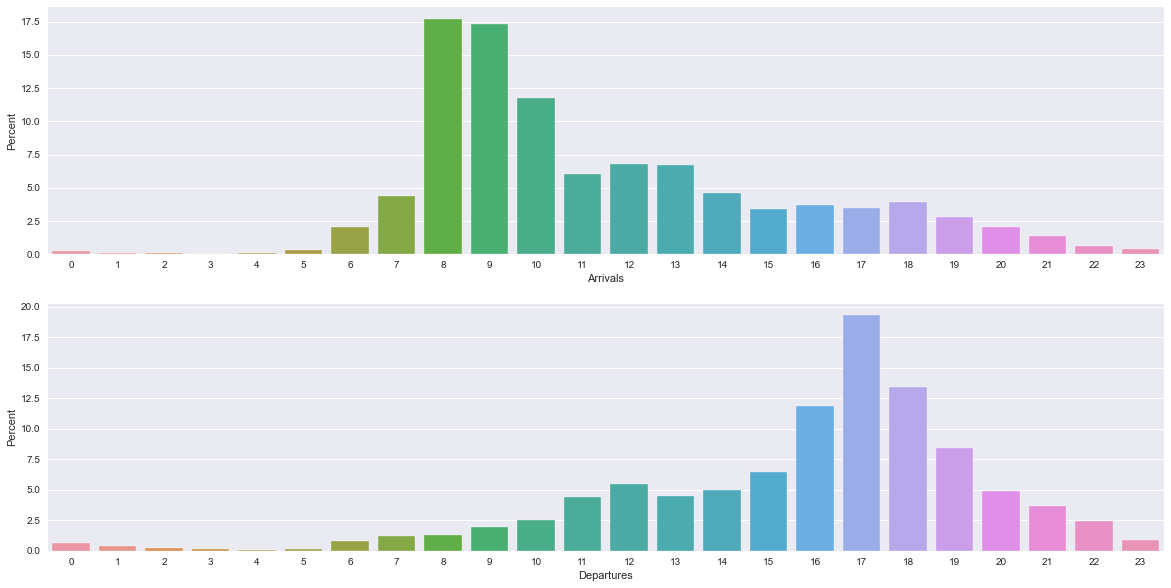

In [148]:
fig, ax = plt.subplots(2, figsize = (20,10))
sns.barplot(x="arrivals",
                 y="arrivals",
                 data=dfCal,
                
                 estimator=lambda x: len(x) / len(dfCal) * 100, ax=ax[0]
                 )
sns.barplot(x="departures",
                 y="departures",
                 data=dfCal,
                 
                 estimator=lambda x: len(x) / len(dfCal) * 100, ax=ax[1]
                 )
ax[0].set(xlabel="Arrivals")
ax[0].set(ylabel="Percent")
ax[1].set(xlabel="Departures")
ax[1].set(ylabel="Percent")
plt.show()

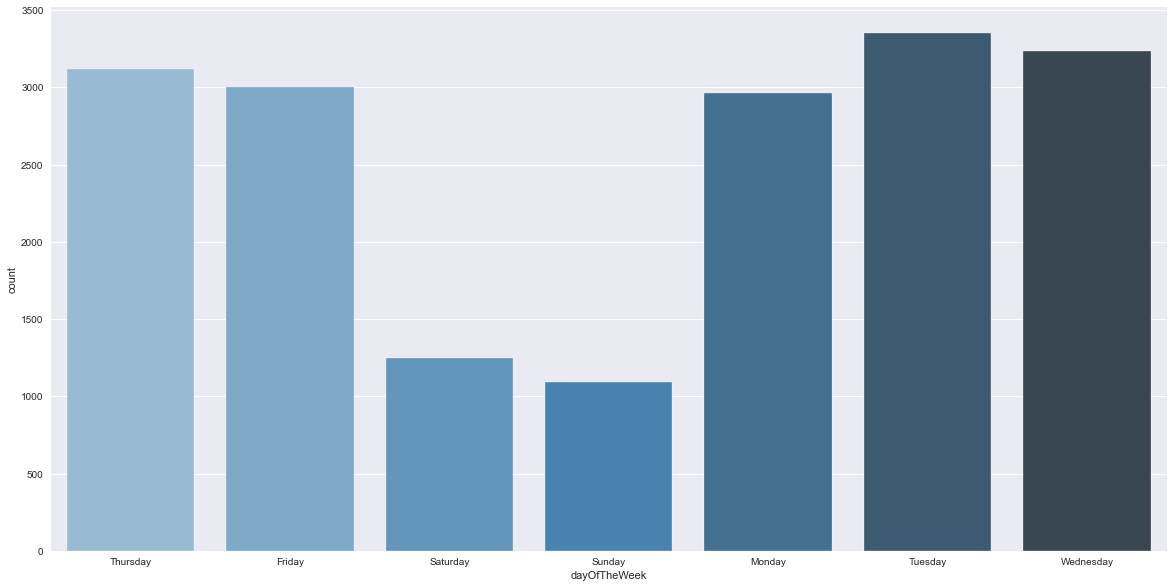

In [157]:
fig, ax = plt.subplots( figsize = (20,10))
ax = sns.countplot(data = dfCal, x = 'dayOfTheWeek', ax=ax, palette = ("Blues_d"))

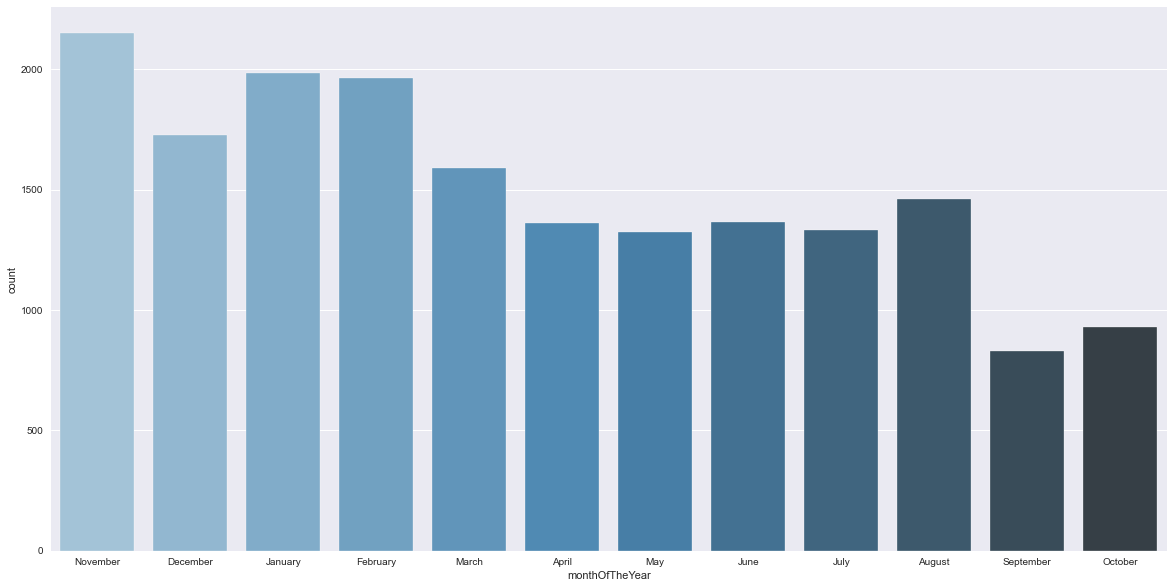

In [158]:
fig, ax = plt.subplots( figsize = (20,10))
ax = sns.countplot(data = dfCal, x = 'monthOfTheYear', ax=ax, palette = ("Blues_d"))

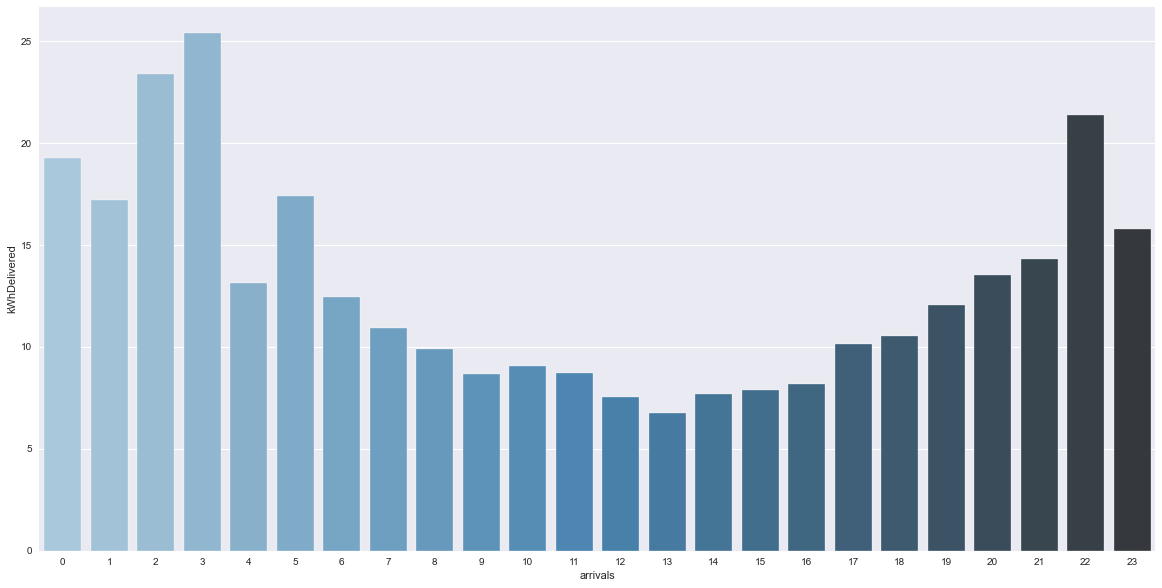

In [149]:
fig, ax = plt.subplots( figsize = (20,10))
ax = sns.barplot(data = dfCal, x = 'arrivals', y='kWhDelivered', ax=ax, palette = ("Blues_d"),ci=None)

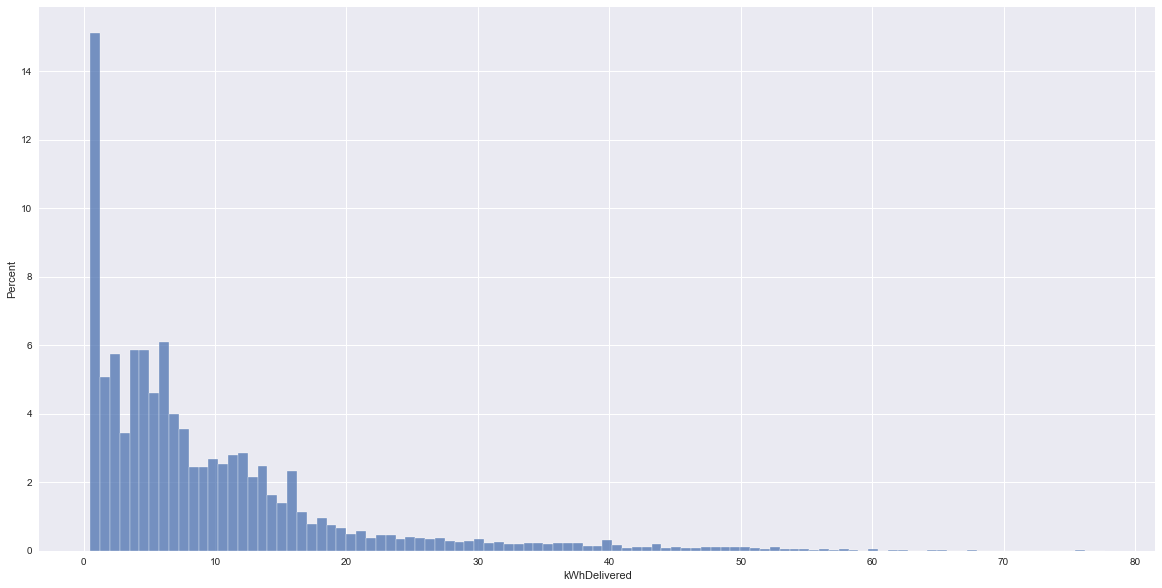

In [150]:
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(data=dfCal, x='kWhDelivered', stat='percent')
plt.show()

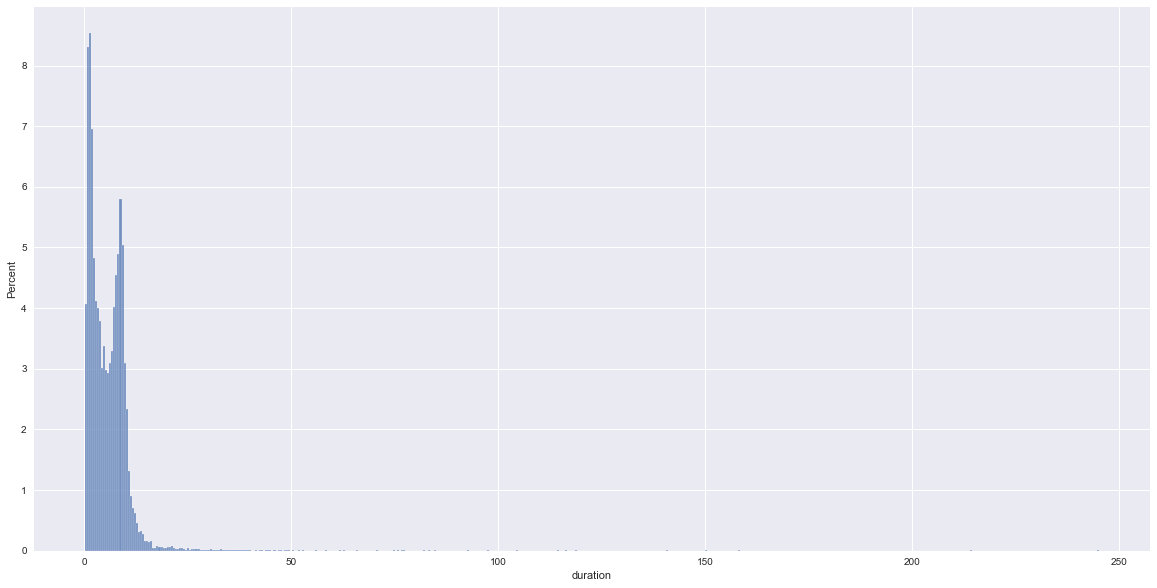

In [151]:
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(data=dfCal, x='duration', stat='percent')
plt.show()